Liz Rightmire

N1 Health Challenge

November 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Data

In [2]:
cities = pd.read_csv("Datasets/500cities/500cities.csv")
# Split the 'Place_TractID' column on the hyphen and take the first 5 digits of the second part
cities['County_FIPS'] = cities['Place_TractID'].str.split('-').str[1].str[:5]
# Remove rows where 'County_FIPS' is NaN
cities = cities.dropna(subset=['County_FIPS'])

# Convert 'County_FIPS' to an integer
cities['County_FIPS'] = cities['County_FIPS'].astype(int)
cities.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,County_FIPS
0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,"(30.1, 32.2)",...,20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)",1073
1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,"(29.3, 31.7)",...,22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)",1073
2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,"(30.2, 32.9)",...,19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)",1073
3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,"(33.5, 36.4)",...,21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)",1073
4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,"(34.9, 37.7)",...,25.5,"(23.1, 28.0)",48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)",1073


In [3]:
access = pd.read_csv("Datasets/FoodEnvironmentAtlas/access.csv")
access

,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
0,1001,AL,Autauga,18428.439690,17496.693040,-5.056026,33.769657,32.062255,5344.427472,6543.676824,...,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808
1,1003,AL,Baldwin,35210.814080,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,...,1377.874834,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712
2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,...,509.377525,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025
3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,...,8.596762,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951
4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,...,497.489891,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914186,0.353990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Sweetwater,13391.715500,18934.737810,41.391428,30.570505,43.224074,2414.618816,4750.905615,...,2661.350520,6.075311,114.722086,0.261887,189.621441,0.432866,27.720443,0.063280,1605.391465,3.664775
3139,56039,WY,Teton,6212.423697,6212.390430,-0.000535,29.174527,29.174370,1059.463554,1577.771012,...,736.174507,3.457192,53.489780,0.251196,32.482255,0.152542,8.468847,0.039771,460.434464,2.162273
3140,56041,WY,Uinta,4270.147119,4686.017653,9.739021,20.220414,22.189685,1518.415783,2054.179828,...,535.616715,2.536304,13.831709,0.065497,40.339658,0.191020,6.586104,0.031187,350.320469,1.658871
3141,56043,WY,Washakie,931.411647,931.411647,0.000000,10.915407,10.915407,233.628356,309.030331,...,35.474502,0.415733,6.366775,0.074614,5.006976,0.058678,0.000000,0.000000,34.160542,0.400334


In [4]:
insecurity = pd.read_csv("Datasets/FoodEnvironmentAtlas/insecurity.csv")
insecurity

,FIPS,State,County,FOODINSEC_12_14,FOODINSEC_15_17,CH_FOODINSEC_14_17,VLFOODSEC_12_14,VLFOODSEC_15_17,CH_VLFOODSEC_14_17,Unnamed: 9
0,1001,AL,Autauga,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
1,1003,AL,Baldwin,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
2,1005,AL,Barbour,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
3,1007,AL,Bibb,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
4,1009,AL,Blount,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Sweetwater,14.0,13.2,-0.8,5.3,5.1,-0.2,NaN
3139,56039,WY,Teton,14.0,13.2,-0.8,5.3,5.1,-0.2,NaN
3140,56041,WY,Uinta,14.0,13.2,-0.8,5.3,5.1,-0.2,NaN
3141,56043,WY,Washakie,14.0,13.2,-0.8,5.3,5.1,-0.2,NaN


In [5]:
health = pd.read_csv("Datasets/FoodEnvironmentAtlas/health.csv")
health

,FIPS,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS12,PCT_OBESE_ADULTS17,PCT_HSPA17,RECFAC11,RECFAC16,PCH_RECFAC_11_16,RECFACPTH11,RECFACPTH16,PCH_RECFACPTH_11_16
0,1001,AL,Autauga,11.4,13.0,33.0,36.3,NaN,4,6,50.000000,0.072465,0.108542,49.785629
1,1003,AL,Baldwin,9.8,10.4,33.0,36.3,NaN,16,21,31.250000,0.085775,0.101200,17.983256
2,1005,AL,Barbour,13.6,18.4,33.0,36.3,NaN,2,0,-100.000000,0.073123,0.000000,-100.000000
3,1007,AL,Bibb,11.1,14.8,33.0,36.3,NaN,0,1,NaN,0.000000,0.044183,NaN
4,1009,AL,Blount,11.4,14.1,33.0,36.3,NaN,3,4,33.333333,0.052118,0.069490,33.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Sweetwater,6.8,8.1,24.6,28.8,NaN,4,6,50.000000,0.090882,0.135609,49.213470
3139,56039,WY,Teton,4.1,4.8,24.6,28.8,NaN,9,13,44.444444,0.419072,0.560828,33.826095
3140,56041,WY,Uinta,6.3,9.0,24.6,28.8,NaN,3,2,-33.333333,0.143548,0.096567,-32.728180
3141,56043,WY,Washakie,10.5,12.0,24.6,28.8,NaN,1,1,0.000000,0.118203,0.122130,3.321935


In [6]:
stores = pd.read_csv("Datasets/FoodEnvironmentAtlas/stores.csv")
stores['stores_per_1000'] = stores['GROCPTH16'] + stores['SUPERCPTH16'] + stores['CONVSPTH16'] + stores['SPECSPTH16']
stores

,FIPS,State,County,GROC11,GROC16,PCH_GROC_11_16,GROCPTH11,GROCPTH16,PCH_GROCPTH_11_16,SUPERC11,...,SNAPSPTH12,SNAPSPTH17,PCH_SNAPSPTH_12_17,WICS11,WICS16,PCH_WICS_11_16,WICSPTH11,WICSPTH16,PCH_WICSPTH_11_16,stores_per_1000
0,1001,AL,Autauga,5,3,-40.000000,0.090581,0.054271,-40.085748,1,...,0.674004,0.804747,19.397900,5.0,5.0,0.000000,0.090567,0.090511,-0.061543,0.651254
1,1003,AL,Baldwin,27,29,7.407407,0.144746,0.139753,-3.449328,6,...,0.725055,0.890836,22.864524,26.0,28.0,7.692307,0.139380,0.134802,-3.284727,0.872251
2,1005,AL,Barbour,6,4,-33.333333,0.219370,0.155195,-29.254287,0,...,1.280590,1.424614,11.246689,7.0,6.0,-14.285714,0.255942,0.232387,-9.203081,1.008769
3,1007,AL,Bibb,6,5,-16.666667,0.263794,0.220916,-16.254289,1,...,0.719122,0.801423,11.444711,6.0,5.0,-16.666666,0.263771,0.221474,-16.035471,0.927849
4,1009,AL,Blount,7,5,-28.571429,0.121608,0.086863,-28.571429,1,...,0.657144,0.692374,5.361034,8.0,8.0,0.000000,0.139000,0.139089,0.064332,0.573295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Sweetwater,5,4,-20.000000,0.113603,0.090406,-20.419482,1,...,0.428936,0.625948,45.930131,4.0,4.0,0.000000,0.090948,0.090344,-0.664035,0.632840
3139,56039,WY,Teton,5,11,120.000000,0.232818,0.474547,103.827437,0,...,0.242215,0.343864,41.966780,3.0,3.0,0.000000,0.140095,0.129528,-7.542849,1.639344
3140,56041,WY,Uinta,3,2,-33.333333,0.143548,0.096567,-32.728180,1,...,0.554895,0.744084,34.094553,3.0,3.0,0.000000,0.143589,0.144991,0.976268,0.869103
3141,56043,WY,Washakie,2,2,0.000000,0.236407,0.244260,3.321935,0,...,0.669502,0.754382,12.677988,2.0,2.0,0.000000,0.236742,0.244858,3.428013,0.610650


# Simple Map

<Axes: >

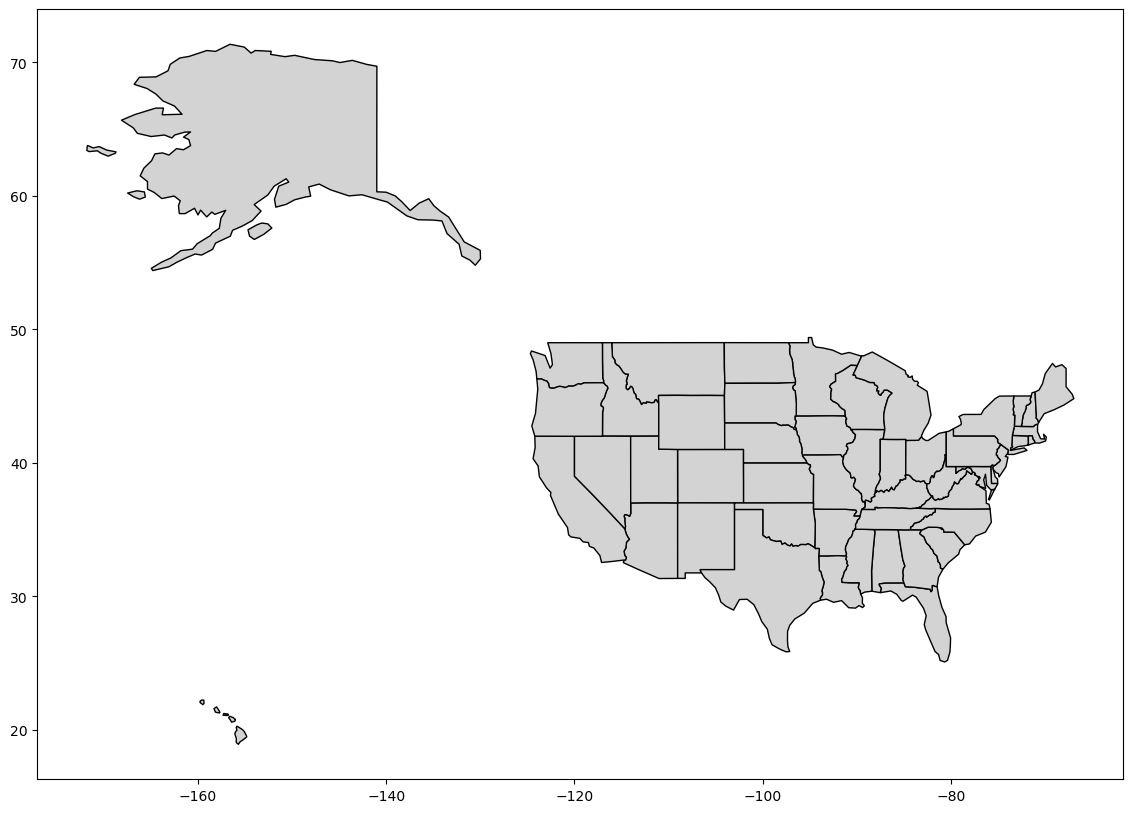

In [7]:
# Load the dataset
states = gpd.read_file("states/states.shp")

# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='lightgray', edgecolor='black')

# Cities Map

Merged

In [8]:
# select columns from cities
cities_filtered = cities[['County_FIPS', 'PlaceName', 'Geolocation']]
#cities_filtered = cities_filtered.drop_duplicates(subset=['County_FIPS', 'PlaceName'])


# select columns from access
access_filtered = access[["FIPS", "County", "PCT_LACCESS_LOWI15", "PCT_LACCESS_HHNV15"]]

# Merge the cities DataFrame with the Food Atlas DataFrame on FIPS
merged_data = pd.merge(cities_filtered, access_filtered, 
                       left_on= "County_FIPS", 
                       right_on = "FIPS",
                       how="inner")

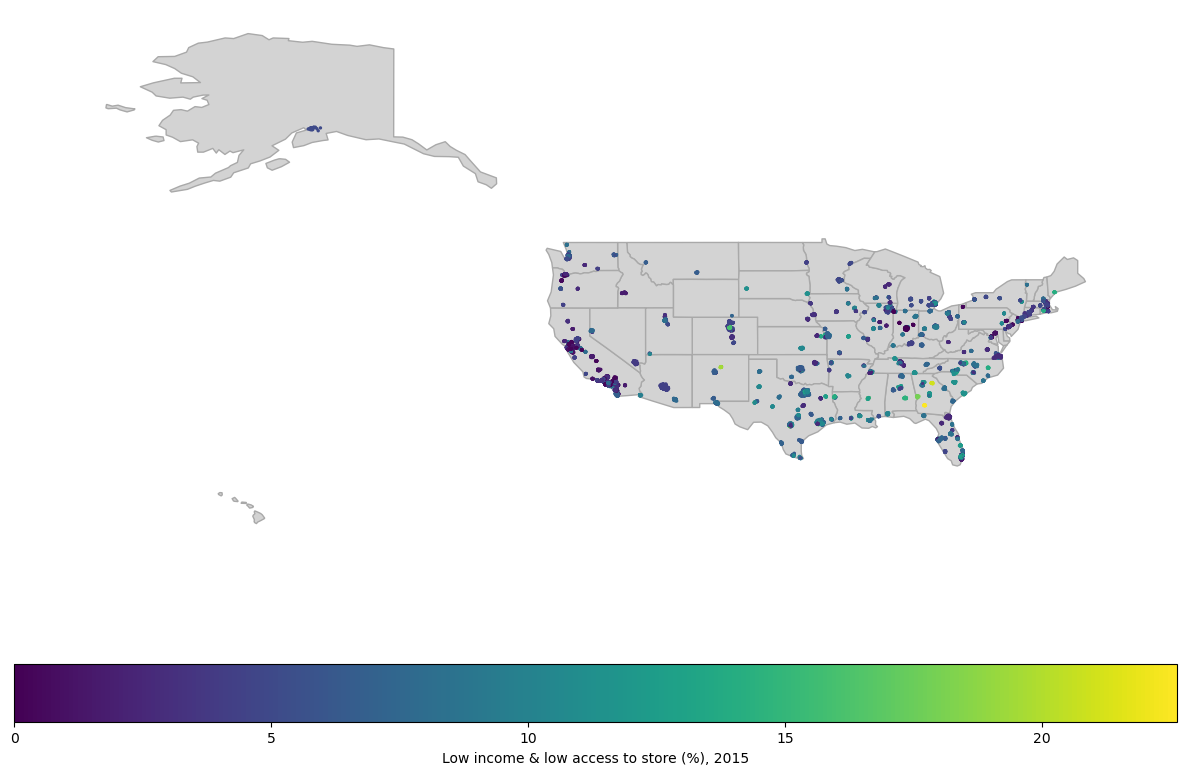

In [9]:
# Clean and preprocess Geolocation
cities['Geolocation'] = cities['Geolocation'].str.strip("()")
cities['Geolocation'] = cities['Geolocation'].apply(lambda x: tuple(map(float, x.split(", "))))
cities['latitude'] = cities['Geolocation'].apply(lambda x: x[0])
cities['longitude'] = cities['Geolocation'].apply(lambda x: x[1])

# Load the dataset
states = gpd.read_file("states/states.shp")

# Create Point geometry
merged_data['geometry'] = cities.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert cities DataFrame into a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='lightgray', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='PCT_LACCESS_LOWI15', 
         cmap='viridis', 
         legend=True, 
         legend_kwds={'label': 'Low income & low access to store (%), 2015', 'orientation': 'horizontal'},
         ax=ax, 
         markersize=2)

# Customize the plot
plt.axis("off")
plt.show()

In [10]:
# Load shapefile of U.S. counties
#gdf = gpd.read_file('Datasets/counties/tl_2024_us_county.shp')

# Calculate centroids for each county
#gdf['centroid'] = gdf.geometry.centroid

# Priority List

In [35]:
# big merge
merged_atlas = pd.merge(access[["FIPS",  "State", "County", "PCT_LACCESS_LOWI15", "LACCESS_LOWI15", "PCT_LACCESS_HHNV15",  "LACCESS_HHNV15"]], 
                        stores[["FIPS", "GROC16"]],
                       on= "FIPS", 
                       how="inner")

# Rename specific columns
merged_atlas = merged_atlas.rename(columns={'PCT_LACCESS_LOWI15': 'Low income & low access to store (%)', 
                                            'PCT_LACCESS_HHNV15': 'Households with no car & low access to store (%)',
                                            })


In [36]:
# Sort the DataFrame by 'food_insec' in descending order and get the top 20 counties
top_20_insecurity = merged_atlas.sort_values(by='LACCESS_LOWI15', ascending=False).head(20)

# Display the top 20 counties
top_20_insecurity

,FIPS,State,County,Low income & low access to store (%),LACCESS_LOWI15,Households with no car & low access to store (%),LACCESS_HHNV15,GROC16
2623,48201,TX,Harris,6.340430,259479.51600,0.897314,12877.845970,766
2537,48029,TX,Bexar,10.666262,182902.18260,2.251181,13708.141130,172
103,4013,AZ,Maricopa,4.399473,167933.01710,0.980829,13845.220200,467
2579,48113,TX,Dallas,6.969852,165055.77860,1.204117,10306.760520,408
2630,48215,TX,Hidalgo,21.250282,164640.59720,2.440150,5282.217853,67
221,6071,CA,San Bernardino,8.004312,162904.56730,1.273486,7788.867685,309
204,6037,CA,Los Angeles,1.647795,161790.52130,0.256088,8300.319629,1980
218,6065,CA,Riverside,6.848193,149950.84750,1.078909,7404.122109,349
2742,48439,TX,Tarrant,8.033122,145321.89990,1.275880,8384.244218,240
2506,47157,TN,Shelby,11.309213,104909.23660,2.259819,7931.307970,163


# Food Atlas with Coordinates

In [37]:
counties = pd.read_csv("us_county_latlng.csv")
counties

,fips_code,name,lng,lat
0,1059,Franklin,-87.843283,34.442381
1,13111,Fannin,-84.319296,34.864126
2,19109,Kossuth,-94.206898,43.204140
3,40115,Ottawa,-94.810589,36.835878
4,42115,Susquehanna,-75.800905,41.821277
...,...,...,...,...
3228,12029,Dixie,-83.158705,29.608068
3229,18017,Cass,-86.346207,40.761660
3230,26091,Lenawee,-84.066412,41.894694
3231,72003,Aguada,-67.175247,18.360392


In [38]:
# merge time
# cite: https://gist.github.com/russellsamora/12be4f9f574e92413ea3f92ce1bc58e6
merged_with_geo = pd.merge(merged_atlas, 
                        counties,
                        left_on= "FIPS", 
                        right_on = "fips_code",
                        how="inner")

merged_with_geo

,FIPS,State,County,Low income & low access to store (%),LACCESS_LOWI15,Households with no car & low access to store (%),LACCESS_HHNV15,GROC16,fips_code,name,lng,lat
0,1001,AL,Autauga,11.991125,6543.676824,3.351332,677.672769,3,1001,Autauga,-86.642900,32.535142
1,1003,AL,Baldwin,5.424427,9886.831137,1.905114,1394.162766,29,1003,Baldwin,-87.722745,30.727825
2,1005,AL,Barbour,10.739667,2948.790251,4.329378,425.144927,4,1005,Barbour,-85.391068,31.870090
3,1007,AL,Bibb,2.601627,596.162829,2.821427,224.388125,5,1007,Bibb,-87.126814,32.998376
4,1009,AL,Blount,2.880150,1650.959482,3.336414,719.931444,5,1009,Blount,-86.567006,33.980871
...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,WY,Sweetwater,10.845331,4750.905615,2.182752,359.608360,4,56037,Sweetwater,-108.879388,41.659762
3138,56039,WY,Teton,7.409463,1577.771012,0.540222,48.474161,11,56039,Teton,-110.589698,43.934564
3139,56041,WY,Uinta,9.727151,2054.179828,2.759922,211.630840,2,56041,Uinta,-110.547405,41.287497
3140,56043,WY,Washakie,3.621591,309.030331,1.203633,42.030853,2,56043,Washakie,-107.682315,43.904378


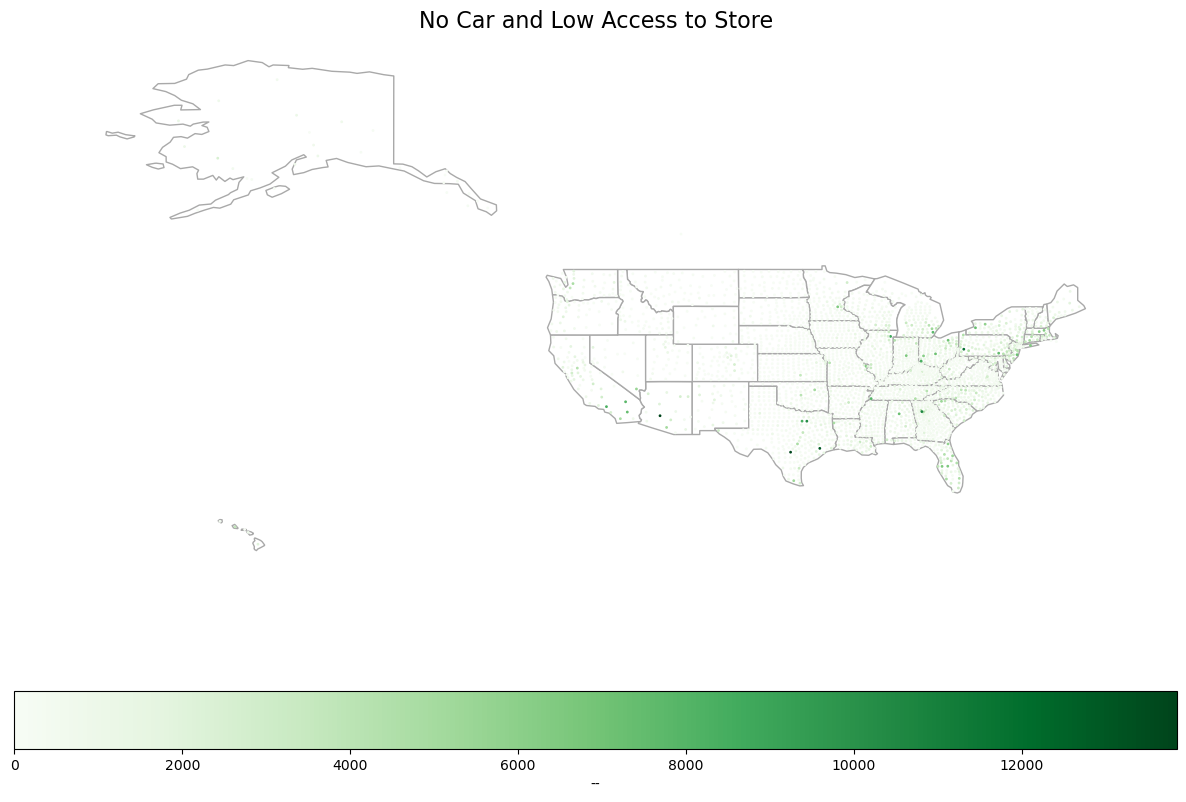

In [39]:
# Create Point geometry
merged_with_geo['geometry'] = merged_with_geo.apply(lambda row: Point(row['lng'], row['lat']), axis=1)

# Convert cities DataFrame into a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_with_geo, geometry='geometry')

# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='white', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='LACCESS_HHNV15', 
         cmap='Greens', 
         legend=True, 
         legend_kwds={'label': '--', 'orientation': 'horizontal'},
         ax=ax, 
         markersize=1)

# Customize the plot
ax.set_title("No Car and Low Access to Store", fontsize=16)
plt.axis("off")
plt.show()

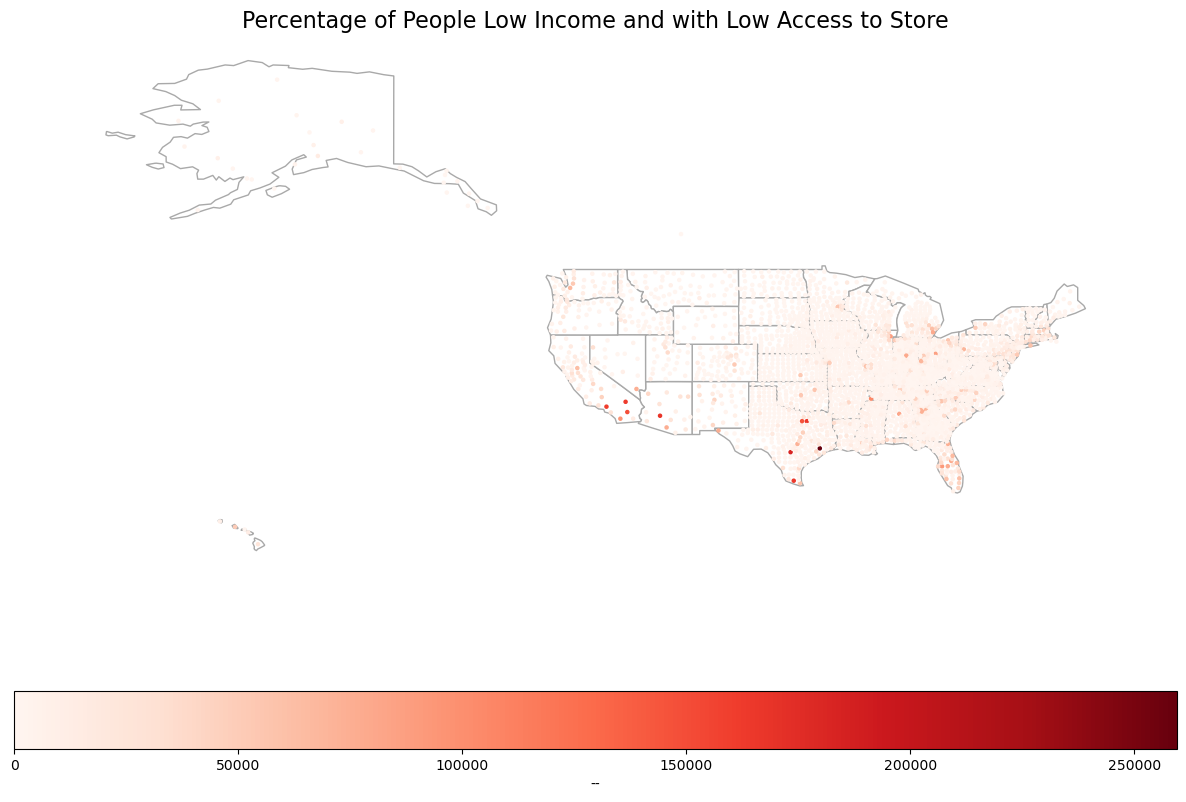

In [27]:
# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='white', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='LACCESS_LOWI15', 
         cmap='Reds', 
         legend=True, 
         legend_kwds={'label': '--', 'orientation': 'horizontal'},
         ax=ax, 
         markersize=5)

# Customize the plot
ax.set_title("Low Income and with Low Access to Store", fontsize=16)
plt.axis("off")
plt.show()